In [1]:
import time
import unittest
from test.test_crop import Test_saturation_vapor_pressure

import cupy as cp
import dask
import numpy as np
import pandas as pd
import dask.array as da
import src.geocat.comp.crop as geo
import xarray as xr
csvpath = "saturation_vapor_pressure_ported_test_numpy.csv"

## Plotting and Validation

In [2]:
import matplotlib.pyplot as plt
import numpy as np

def plot(allData,name):
    arraysizes = np.unique(allData['ArraySize'])
    sd_numpy = np.zeros(len(arraysizes))
    sd_cupy = np.zeros(len(arraysizes))
    y_numpy = np.zeros(len(arraysizes))
    y_cupy = np.zeros(len(arraysizes))
    plt.rcParams.update({'font.size': 15})
    for i in range(0,len(arraysizes)):
        cupydata = allData.loc[(allData['ArraySize'] == arraysizes[i]) & (allData['Approach'] == 'cupy')]
        numpydata = allData.loc[(allData['ArraySize'] == arraysizes[i]) & (allData['Approach'] == 'numpy')]
        y_cupy[i] = np.mean(cupydata['Runtime(s)'])
        y_numpy[i] = np.mean(numpydata['Runtime(s)'])
        sd_cupy[i] = np.std(cupydata['Runtime(s)'])
        sd_numpy[i] = np.std(numpydata['Runtime(s)'])
    fig, ax = plt.subplots(figsize=(9, 6))
    ax.errorbar(arraysizes, y_numpy, yerr=sd_numpy, fmt='-o',label='numpy')
    ax.errorbar(arraysizes, y_cupy, yerr=sd_cupy, fmt='-o',label='cupy')
    ax.legend();  # Add a legend.
    ax.set_xlabel('ArraySize')  # Add an x-label to the axes.
    ax.set_ylabel('Runtime(s)')  # Add a y-label to the axes.
    ax.set_title(("Test_saturation_vapor_pressure"))
    ax.set_xscale('log')
    ax.set_yscale('log')
    plt.savefig(name,dpi=fig.dpi)

def test_validation(res_numpy,res_cupy):
    assert np.allclose(res_numpy,res_cupy, atol=0.0000001)

## Cluster

### CPU cluster on PBS cluster

In [3]:
# import dask.array as da
from dask_jobqueue import PBSCluster
from dask.distributed import Client

clusterCPU = PBSCluster(memory='100 GB',
                     processes=3,
                     cores=3,
                     queue='casper',
                     walltime='02:00:00',
                     resource_spec='select=1:ncpus=3:mem=100gb')
print(clusterCPU.job_script())
clusterCPU.scale(1)
client = Client(clusterCPU)
#cluster.close()


/glade/work/hkashgar/conda-envs/geocat/lib/python3.10/site-packages/dask_jobqueue/core.py:20: FutureWarning: tmpfile is deprecated and will be removed in a future release. Please use dask.utils.tmpfile instead.
  from distributed.utils import tmpfile


#!/usr/bin/env bash

#PBS -N dask-worker
#PBS -q casper
#PBS -A NTDD0005
#PBS -l select=1:ncpus=3:mem=100gb
#PBS -l walltime=02:00:00

/glade/work/hkashgar/conda-envs/geocat/bin/python -m distributed.cli.dask_worker tcp://10.12.205.44:33982 --nthreads 1 --nprocs 3 --memory-limit 31.04GiB --name dummy-name --nanny --death-timeout 60 --interface ib0 --protocol tcp://



In [4]:
client

Connection method: Cluster object,Cluster type: dask_jobqueue.PBSCluster
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/hkashgar/proxy/8787/status,
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/hkashgar/proxy/8787/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://10.12.205.44:33982,Workers: 0
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/hkashgar/proxy/8787/status,Total threads: 0
Started: Just now,Total memory: 0 B


### CUDA cluster on PBS cluster

In [5]:
# import dask.array as da
from dask_jobqueue import PBSCluster
from dask.distributed import Client

clusterCUDA = PBSCluster(memory='200 GB',
                     processes=1,
                     cores=1,
                     queue='casper',
                     walltime='02:00:00',
                     resource_spec='select=1:ncpus=1:ngpus=1:mem=200gb')
print(clusterCUDA.job_script())
clusterCUDA.scale(1)
client = Client(clusterCUDA)
#cluster.close()

#!/usr/bin/env bash

#PBS -N dask-worker
#PBS -q casper
#PBS -A NTDD0005
#PBS -l select=1:ncpus=1:ngpus=1:mem=200gb
#PBS -l walltime=02:00:00

/glade/work/hkashgar/conda-envs/geocat/bin/python -m distributed.cli.dask_worker tcp://10.12.205.44:35638 --nthreads 1 --memory-limit 186.26GiB --name dummy-name --nanny --death-timeout 60 --interface ib0 --protocol tcp://



/glade/work/hkashgar/conda-envs/geocat/lib/python3.10/site-packages/distributed/node.py:177: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 35941 instead
  warnings.warn(


In [6]:
client

Connection method: Cluster object,Cluster type: dask_jobqueue.PBSCluster
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/hkashgar/proxy/35941/status,
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/hkashgar/proxy/35941/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://10.12.205.44:35638,Workers: 0
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/hkashgar/proxy/35941/status,Total threads: 0
Started: Just now,Total memory: 0 B


## Initializing Arrays

In [7]:
max_power = 8
chunksize = 10**5
temp_arrays = []
for i in range(1,max_power):
    temp_arrays.append(xr.DataArray(np.arange(1, 10**i+1, 1)))
numpy_results = []
cupy_results = []

## Testing Numpy input and CPU

In [8]:
xp = np
for i in range(max_power-1):
    temp = temp_arrays[i].data
    ncl_gt1 = geo.saturation_vapor_pressure(temp, use_gpu = False)

In [9]:
type(ncl_gt1)

numpy.ndarray

## Testing Numpy input and GPU

In [10]:
for i in range(max_power-1):
    temp = temp_arrays[i].data
    ncl_gt2 = geo.saturation_vapor_pressure(temp, use_gpu = True)

In [11]:
type(ncl_gt2)

cupy._core.core.ndarray

# this function is not ported for xarray and dask since cp.exp doesn't recognize dask and xarray

## Testing Xarray input and CPU

In [12]:
from src.geocat.comp.comp_util import _is_duck_array, _convert_to_gpu_array

In [13]:
for i in range(max_power-1):
    temp = temp_arrays[i]
    ncl_gt1 = geo.saturation_vapor_pressure(temp, use_gpu = False)

In [14]:
type(ncl_gt1.data)

numpy.ndarray

## Testing Xarray input and GPU

In [15]:
for i in range(max_power-1):
    temp = temp_arrays[i]
    ncl_gt2 = geo.saturation_vapor_pressure(temp, use_gpu = True)

In [17]:
ncl_gt2.data

array([              nan,               nan,               nan, ...,
       19312761.49224298, 19312761.49366752, 19312761.49509206])

## Testing Dask input with CPU

In [18]:
client = Client(clusterCPU)
for i in range(2):
    temp = temp_arrays[i].chunk(10)
    ncl_gt1 = geo.saturation_vapor_pressure(temp, use_gpu = False).compute()

In [19]:
ncl_gt1

<xarray.DataArray (dim_0: 100)>
array([       nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan, 0.63594167, 0.66199376, 0.68898447,
       0.71694272, 0.74589816, 0.77588118, 0.80692291, 0.83905527,
       0.87231096, 0.90672347, 0.94232709, 0.97915697, 1.01724907,
       1.05664022, 1.09736811, 1.13947134, 1.18298937, 1.22796262,
       1.27443241, 1.32244103, 1.37203171, 1.42324869, 1.47613717,
       1.53074338, 1.58711459, 1.64529908, 1.70534623, 1.76730647,
       1.83123133, 1.89717346, 1.96518663, 2.03532576, 2.10764693,
       2.18220739, 2.25906562, 2.33828127, 2.41991527, 2.50402976,
       2.59068819, 2.67995525, 2.77189698, 2.86658072, 2.96407517,
       3.06445035, 3.16777772, 3.27413009, 3.3835817 , 3.49620825,
       3.61208687, 3.73129616, 3.85391624, 3.98002873, 4.10971676,
       4.24306506, 4.38015989, 4.52108912, 4.66594223, 4.81481034,
       4.96778619, 5.12496422, 5.28644057, 5.45231305, 5.62268124,
       5.79764645, 5.97731179, 6.16178212, 6.35116414, 6.54556639])
Dimensions without coordinates: dim_0
Attributes:
    long_name:  saturation vapor pressure
    units:      kPa
    url:        https://www.fao.org/docrep/X0490E/x0490e07.htm
    info:       FAO 56; EQN 11; saturation_vapor_pressure

## Testing Dask input with GPU

In [20]:
#client = Client(clusterCUDA)
for i in range(2):
    temp = temp_arrays[i].chunk(10)
    ncl_gt2 = geo.saturation_vapor_pressure(temp, use_gpu = True).compute()

In [21]:
ncl_gt2

<xarray.DataArray (dim_0: 100)>
array([       nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan, 0.63594167, 0.66199376, 0.68898447,
       0.71694272, 0.74589816, 0.77588118, 0.80692291, 0.83905527,
       0.87231096, 0.90672347, 0.94232709, 0.97915697, 1.01724907,
       1.05664022, 1.09736811, 1.13947134, 1.18298937, 1.22796262,
       1.27443241, 1.32244103, 1.37203171, 1.42324869, 1.47613717,
       1.53074338, 1.58711459, 1.64529908, 1.70534623, 1.76730647,
       1.83123133, 1.89717346, 1.96518663, 2.03532576, 2.10764693,
       2.18220739, 2.25906562, 2.33828127, 2.41991527, 2.50402976,
       2.59068819, 2.67995525, 2.77189698, 2.86658072, 2.96407517,
       3.06445035, 3.16777772, 3.27413009, 3.3835817 , 3.49620825,
       3.61208687, 3.73129616, 3.85391624, 3.98002873, 4.10971676,
       4.24306506, 4.38015989, 4.52108912, 4.66594223, 4.81481034,
       4.96778619, 5.12496422, 5.28644057, 5.45231305, 5.62268124,
       5.79764645, 5.97731179, 6.16178212, 6.35116414, 6.54556639])
Dimensions without coordinates: dim_0
Attributes:
    long_name:  saturation vapor pressure
    units:      kPa
    url:        https://www.fao.org/docrep/X0490E/x0490e07.htm
    info:       FAO 56; EQN 11; saturation_vapor_pressure

## Unittests with CPU!

In [22]:
client = Client(clusterCPU)
test = Test_saturation_vapor_pressure()

test.setUpClass()
test.test_float_input(use_gpu = False)
test.test_list_input(use_gpu = False)
test.test_numpy_input(use_gpu = False)
test.test_multi_dimensional_input(use_gpu = False)
test.test_xarray_input(use_gpu = False)
test.test_dask_compute(use_gpu = False)
test.test_dask_lazy(use_gpu = False)

/glade/work/hkashgar/conda-envs/geocat/lib/python3.10/site-packages/distributed/node.py:177: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 41265 instead
  warnings.warn(
2022-07-15 08:32:36,894 - distributed.diskutils - INFO - Found stale lock file and directory '/glade/u/home/hkashgar/GPU_data_analysis_rapids/geocat-comp/dask-worker-space/worker-500y0azl', purging
2022-07-15 08:32:36,908 - distributed.diskutils - INFO - Found stale lock file and directory '/glade/u/home/hkashgar/GPU_data_analysis_rapids/geocat-comp/dask-worker-space/worker-g2yfu8ma', purging
2022-07-15 08:32:36,919 - distributed.diskutils - INFO - Found stale lock file and directory '/glade/u/home/hkashgar/GPU_data_analysis_rapids/geocat-comp/dask-worker-space/worker-9nafh35f', purging


In [23]:
xr.ufuncs.exp

## Unittests with GPU

In [24]:
client = Client(clusterCUDA)
test = Test_saturation_vapor_pressure()

test.setUpClass()
test.test_float_input(use_gpu = True)
test.test_list_input(use_gpu = True)
test.test_numpy_input(use_gpu = True)
test.test_multi_dimensional_input(use_gpu = True)
test.test_xarray_input(use_gpu = True)
test.test_dask_compute(use_gpu = True)
test.test_dask_lazy(use_gpu = True)

/glade/work/hkashgar/conda-envs/geocat/lib/python3.10/site-packages/distributed/node.py:177: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 33582 instead
  warnings.warn(


In [26]:
res_numpy

array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan])

In [27]:
res_cupy

array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan])

## Benchmark Results for different Array Sizes (NUMPY/CUPY)

saturation_vapor_pressure
Array size:  100
numpy 2.2649765014648438e-05 seconds
cupy 0.0003327608108520508 seconds
Array size:  1000
numpy 2.5796890258789063e-05 seconds
cupy 0.0003088474273681641 seconds
Array size:  10000
numpy 8.478164672851563e-05 seconds
cupy 0.00034143924713134763 seconds
Array size:  100000
numpy 0.0015781402587890625 seconds
cupy 0.0004999876022338867 seconds
Array size:  1000000
numpy 0.018692326545715333 seconds
cupy 0.002646732330322266 seconds
Array size:  10000000
numpy 0.2667424440383911 seconds
cupy 0.027664923667907716 seconds


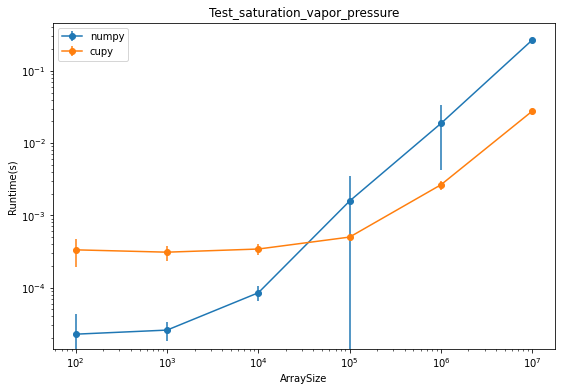

In [29]:
#Test_saturation_vapor_pressure main body
Routine = "saturation_vapor_pressure"
print(Routine)
allData = pd.DataFrame()
#For different Array sizes
for i in range(2,max_power):
    ArraySize = 10**i
    temp = temp_arrays[i-1].data
    print("Array size: ", ArraySize)
    #for numpy and cupy both
    for xp in [np,cp]:
        #calculation will be repeated 10 time to get the less biased performance results
        repsize = 10
        repeat = np.zeros([repsize])
        for rep in range(0,repsize):
            #create different sizes of arrays
            if(xp == cp):
                res_cupy = geo.saturation_vapor_pressure(temp,use_gpu=True)
                cp.cuda.runtime.deviceSynchronize()
                time1 = time.time()
                res_cupy = geo.saturation_vapor_pressure(temp,use_gpu=True)
                cp.cuda.runtime.deviceSynchronize()
                time2 = time.time()
                repeat[rep] = time2-time1
            else:
                time1 = time.time()
                res_numpy = geo.saturation_vapor_pressure(temp,use_gpu=False)
                time2 = time.time()
                repeat[rep] = time2-time1
        #save times
        data = {'Routine': np.repeat(Routine, repsize),
                'Input':"NumPy input",
                'Approach': np.repeat(xp.__name__ , repsize),
                'ArraySize': np.repeat(ArraySize , repsize),
                'iteration' : np.arange(1,repsize+1),
                'Runtime(s)': repeat}

        allData = pd.concat([allData,pd.DataFrame(data)], ignore_index=True)
        print(xp.__name__,np.mean(repeat), "seconds")
    #test_validation(res_numpy,res_cupy)
try:
    previous = pd.read_csv(csvpath)
    previous = pd.concat([previous,allData])
except FileNotFoundError:
    previous = allData
previous.to_csv(csvpath, index=False)
plot(allData,"Test_saturation_vapor_pressure_ported_numpy.jpg")

## Results for different ArraySizes Xarray (with NumPy/CuPy arrays inside the Xarray)

### Test saturation_vapor_pressure on CPU

In [ ]:
client = Client(clusterCPU)
client

In [ ]:
csvpath = "saturation_vapor_pressure_ported_test_xarray.csv"
#Test_saturation_vapor_pressure main body
Routine = "saturation_vapor_pressure"
print(Routine)
allData = pd.DataFrame()
#For different Array sizes
for i in range(1,max_power):
    ArraySize = 10**i
    print("Array size: ", ArraySize)
    pressure = pressure_arrays[i-1].data
    #for numpy and cupy both
    xp = np 
    repsize = 10
    repeat = np.zeros([repsize])
    for rep in range(0,repsize):
    #create different sizes of arrays
        numpy_res = geo.saturation_vapor_pressure(pressure , False)
        time1 = time.time()
        numpy_res = geo.saturation_vapor_pressure(pressure , False)
        time2 = time.time()
        repeat[rep] = time2-time1
    numpy_results.append(numpy_res)
    #save times
    data = {'Routine': np.repeat(Routine, repsize),
            'Input':"Xarray with NumPy input",
            'Approach': np.repeat(xp.__name__ , repsize),
            'ArraySize': np.repeat(ArraySize , repsize),
            'iteration' : np.arange(1,repsize+1),
            'Runtime(s)': repeat}
    allData = pd.concat([allData,pd.DataFrame(data)], ignore_index=True)
    print(xp.__name__,np.mean(repeat), "seconds")
try:
    previous = pd.read_csv(csvpath)
    previous = pd.concat([previous,allData])
except FileNotFoundError:
    previous = allData
previous.to_csv(csvpath, index=False)

### Test saturation_vapor_pressure on GPU

In [ ]:
client = Client(clusterCUDA)
client

In [ ]:
#Test_saturation_vapor_pressure main body
Routine = "saturation_vapor_pressure"
print(Routine)
#For different Array sizes
for i in range(1,max_power):
    ArraySize = 10**i
    pressure = pressure_arrays[i-1]
    print("Array size: ", ArraySize)
    #for numpy and cupy both
    xp = cp
        #calculation will be repeated 10 time to get the less biased performance results
    repsize = 10
    repeat = np.zeros([repsize])
    for rep in range(0,repsize):
        #create different sizes of arrays
        cupy_res = geo.saturation_vapor_pressure(pressure, True)
        cp.cuda.runtime.deviceSynchronize()
        time1 = time.time()
        cupy_res = geo.saturation_vapor_pressure(pressure, True)
        cp.cuda.runtime.deviceSynchronize()
        time2 = time.time()
        repeat[rep] = time2-time1
    cupy_results.append(cupy_res)
    #save times
    data = {'Routine': np.repeat(Routine, repsize),
            'Input':"Xarray with NumPy input",
            'Approach': np.repeat(xp.__name__ , repsize),
            'ArraySize': np.repeat(ArraySize , repsize),
            'iteration' : np.arange(1,repsize+1),
            'Runtime(s)': repeat}
    allData = pd.concat([allData,pd.DataFrame(data)], ignore_index=True)
    print(xp.__name__,np.mean(repeat), "seconds")

try:
    previous = pd.read_csv(csvpath)
    previous = pd.concat([previous,allData])
except FileNotFoundError:
    previous = allData
previous.to_csv(csvpath, index=False)
plot(allData,"Test_saturation_vapor_pressure_ported_xarray.jpg")

### Validation

In [ ]:
#validation 
for i in range(len(numpy_results)):
    test_validation(cupy_results[i].data,numpy_results[i].data)

In [ ]:
cupy_results[0]

In [ ]:
numpy_results[0]

## Benchmark Results for different ArraySizes Xarray (with Dask arrays inside the Xarray, then dask array type is either NumPy or CuPy)

### Test saturation_vapor_pressure on CPU

In [ ]:
client = Client(clusterCPU)
client

In [ ]:
csvpath = "saturation_vapor_pressure_ported_test_dask.csv"
#Test_saturation_vapor_pressure main body
Routine = "saturation_vapor_pressure"
print(Routine)
allData = pd.DataFrame()
#For different Array sizes
for i in range(1,max_power):
    ArraySize = 10**i
    print("Array size: ", ArraySize)
    rh_def = rh_def_arrays[i-1].chunk(chunksize)
    tk_def = tk_def_arrays[i-1].chunk(chunksize)
    #for numpy and cupy both
    xp = np
    #calculation will be repeated 10 time to get the less biased performance results
    repsize = 10
    repeat = np.zeros([repsize])
    for rep in range(0,repsize):
        #create different sizes of arrays
        numpy_res = geo.saturation_vapor_pressure(tk_def, rh_def, False).compute()
        time1 = time.time()
        numpy_res = geo.saturation_vapor_pressure(tk_def, rh_def, False).compute()
        time2 = time.time()
        repeat[rep] = time2-time1
        #save times
    numpy_results.append(numpy_res)
    data = {'Routine': np.repeat(Routine, repsize),
            'Input':"Xarray with Dask array input",
            'Approach': np.repeat(xp.__name__ , repsize),
            'ArraySize': np.repeat(ArraySize , repsize),
            'iteration' : np.arange(1,repsize+1),
            'Runtime(s)': repeat}
    allData = pd.concat([allData,pd.DataFrame(data)], ignore_index=True)
    print(xp.__name__,np.mean(repeat), "seconds")

try:
    previous = pd.read_csv(csvpath)
    previous = pd.concat([previous,allData])
except FileNotFoundError:
    previous = allData
previous.to_csv(csvpath, index=False)

### Test saturation_vapor_pressure on GPU

In [ ]:
client = Client(clusterCUDA)
client

In [ ]:
#Test_saturation_vapor_pressure main body
Routine = "saturation_vapor_pressure"
print(Routine)
#For different Array sizes
for i in range(1,max_power):
    ArraySize = 10**i
    print("Array size: ", ArraySize)
    rh_def = rh_def_arrays[i-1].chunk(chunksize)
    tk_def = tk_def_arrays[i-1].chunk(chunksize)
    #for numpy and cupy both
    xp = cp
    #calculation will be repeated 10 time to get the less biased performance results
    repsize = 10
    repeat = np.zeros([repsize])
    for rep in range(0,repsize):
        #create different sizes of arrays
        cupy_res = geo.saturation_vapor_pressure(tk_def, rh_def, True).compute()
        cp.cuda.runtime.deviceSynchronize()
        time1 = time.time()
        cupy_res = geo.saturation_vapor_pressure(tk_def, rh_def, True).compute()
        cp.cuda.runtime.deviceSynchronize()
        time2 = time.time()
        repeat[rep] = time2-time1
        #save times
    cupy_results.append(cupy_res)
    data = {'Routine': np.repeat(Routine, repsize),
            'Input':"Xarray with Dask array input",
            'Approach': np.repeat(xp.__name__ , repsize),
            'ArraySize': np.repeat(ArraySize , repsize),
            'iteration' : np.arange(1,repsize+1),
            'Runtime(s)': repeat}
    new = pd.DataFrame(data)
    allData = pd.concat([allData,new], ignore_index=True)
    print(xp.__name__,np.mean(repeat), "seconds")
    #print(np.allclose(cupy_res.data,numpy_res.data,atol=0.0000001))
try:
    previous = pd.read_csv(csvpath)
    previous = pd.concat([previous,allData])
except FileNotFoundError:
    previous = allData
previous.to_csv(csvpath, index=False)

plot(allData,"Test_saturation_vapor_pressure_ported_dask.jpg")

In [ ]:
cupy_res.data

In [ ]:
numpy_res.data

### Validation

In [ ]:
#validation 
for i in range(len(numpy_results)):
    test_validation(cupy_results[i].data,numpy_results[i].data)

In [ ]:
numpy_results[0]

In [ ]:
cupy_results[0]

In [ ]:
len(numpy_results)

### Only comparing "compute()" runtime

In [ ]:
chunksize = 10**5

#### on CPU

In [ ]:
client = Client(clusterCPU)
client

In [ ]:
csvpath = "saturation_vapor_pressure_ported_test_dask_compute_10.csv"
#Test_saturation_vapor_pressure main body
Routine = "saturation_vapor_pressure"
print(Routine)
allData = pd.DataFrame()
#For different Array sizes
for i in range(1,7):
    ArraySize = 10**i
    print("Array size: ", ArraySize)
    rh_def = rh_def_arrays[i-1].chunk(chunksize)
    tk_def = tk_def_arrays[i-1].chunk(chunksize)
    #for numpy and cupy both
    xp = np
    #calculation will be repeated 10 time to get the less biased performance results
    repsize = 10
    repeat = np.zeros([repsize])
    for rep in range(0,repsize):
        #create different sizes of arrays
        numpy_res = geo.saturation_vapor_pressure(tk_def, rh_def,False)
        numpy_res.compute()
        time1 = time.time()
        numpy_res = numpy_res.compute()
        time2 = time.time()
        repeat[rep] = time2-time1
        #save times
    numpy_results.append(numpy_res)
    data = {'Routine': np.repeat(Routine, repsize),
            'Input':"Xarray with Dask array input compute",
            'Approach': np.repeat(xp.__name__ , repsize),
            'ArraySize': np.repeat(ArraySize , repsize),
            'iteration' : np.arange(1,repsize+1),
            'Runtime(s)': repeat}
    allData = pd.concat([allData,pd.DataFrame(data)], ignore_index=True)
    print(xp.__name__,np.mean(repeat), "seconds")

try:
    previous = pd.read_csv(csvpath)
    previous = pd.concat([previous,allData])
except FileNotFoundError:
    previous = allData
previous.to_csv(csvpath, index=False)

#### on GPU

In [ ]:
client = Client(clusterCUDA)
client

In [ ]:
#Test_saturation_vapor_pressure main body
Routine = "saturation_vapor_pressure"
print(Routine)
#For different Array sizes
for i in range(1,7):
    ArraySize = 10**i
    print("Array size: ", ArraySize)
    rh_def = rh_def_arrays[i-1].chunk(chunksize)
    tk_def = tk_def_arrays[i-1].chunk(chunksize)
    #for numpy and cupy both
    xp = cp
    #calculation will be repeated 10 time to get the less biased performance results
    repsize = 10
    repeat = np.zeros([repsize])
    for rep in range(0,repsize):
        #create different sizes of arrays
        cupy_res = geo.saturation_vapor_pressure(tk_def, rh_def,True)
        cupy_res.compute()
        cp.cuda.runtime.deviceSynchronize()
        time1 = time.time()
        cupy_res = cupy_res.compute()
        cp.cuda.runtime.deviceSynchronize()
        time2 = time.time()
        repeat[rep] = time2-time1
        #save times
    cupy_results.append(cupy_res)
    data = {'Routine': np.repeat(Routine, repsize),
            'Input':"Xarray with Dask array input compute",
            'Approach': np.repeat(xp.__name__ , repsize),
            'ArraySize': np.repeat(ArraySize , repsize),
            'iteration' : np.arange(1,repsize+1),
            'Runtime(s)': repeat}
    new = pd.DataFrame(data)
    allData = pd.concat([allData,new], ignore_index=True)
    print(xp.__name__,np.mean(repeat), "seconds")
    #print(np.allclose(cupy_res.data,numpy_res.data,atol=0.0000001))
try:
    previous = pd.read_csv(csvpath)
    previous = pd.concat([previous,allData])
except FileNotFoundError:
    previous = allData
previous.to_csv(csvpath, index=False)

In [ ]:
plot(allData,"Test_saturation_vapor_pressure_ported_compute")

#### Validation

In [ ]:
#validation 
for i in range(len(numpy_results)):
    test_validation(cupy_results[i].data,numpy_results[i].data)